# Assignment #1, Alberto Dicembre

### Fetching Data and counting missing values

In [1]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
  
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets 


print(X.shape)
#remove NMHC column as suggested
X = X.drop("NMHC(GT)", axis = 1)

print(X.shape)

#substituting missing values with nan
X = X.replace(-200, np.nan)

count_nan = X.isna().sum().sum()
print ('Count of NaN: ' + str(count_nan))

(9357, 15)
(9357, 14)
Count of NaN: 8258


## Cleaning data
As suggested, consecutive missing values are taken from same time, previous or successive day. When these are nan values as well, we check the closest day to that, and so on until we find a valid value. 
The non-consecutive missing values, instead, are handled by linear interpolation. 

In [2]:
#Generating the lists of missing values

from itertools import groupby
cols_misses = {}
for col in X.columns:
    missing_data = X[col].isnull()
    consecutive_missing = []
    for k, g in groupby(enumerate(missing_data), lambda x: x[1]):
        if k:
            consecutive_missing.append(list(map(lambda x: x[0], list(g))))
    cols_misses.update({col:consecutive_missing})

In [3]:
#alternate check between day(s) before and day(s) after until we find a non-nan 

for (col_name, cons_list) in cols_misses.items():
    for l in cons_list:
        #only for consecutive nan values
        if len(l) > 1:        
            for el in l:
                    i=0
                    day_offset = -24
                    try:
                        while(np.isnan(X.at[(el + day_offset), col_name])):

                            if(i%2 == 0):
                                day_offset *= -1
                            else:
                                day_offset += (24* np.sign(day_offset))
                            i+=1
                        X.at[el, col_name] = X.at[(el + day_offset), col_name]
                    except KeyError: #If index goes out of range 
                        pass

X = X.interpolate(method='linear', limit_direction='forward', limit=1) #interpolating remaining nans
count_nan = X.isna().sum().sum()
print ('Count of NaN: ' + str(count_nan))


Count of NaN: 0


/tmp/ipykernel_6075/3192829418.py:22: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  X = X.interpolate(method='linear', limit_direction='forward', limit=1) #interpolating remaining nans


### Taking a look at the single sensors


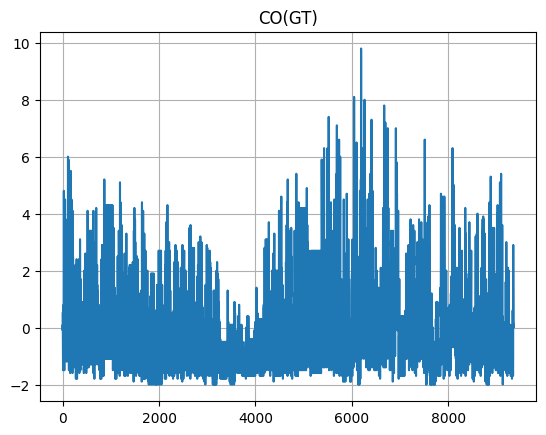

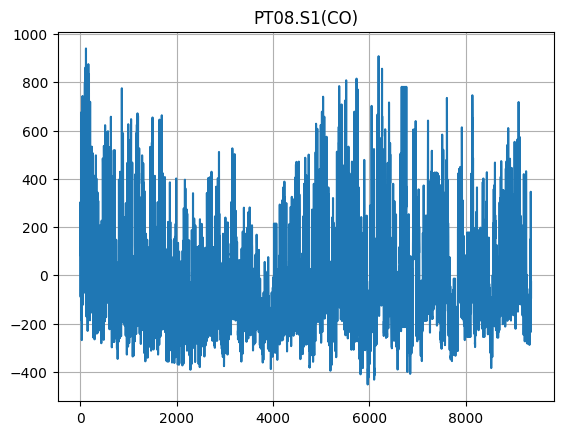

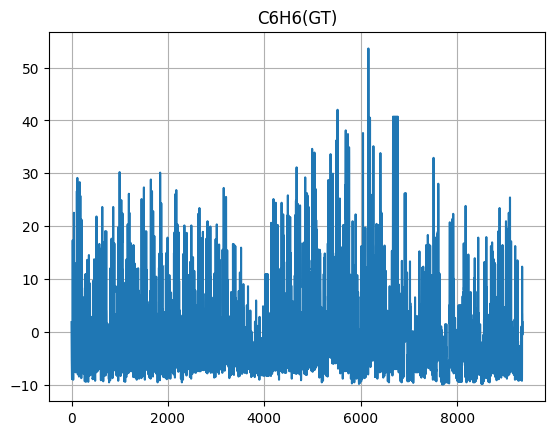

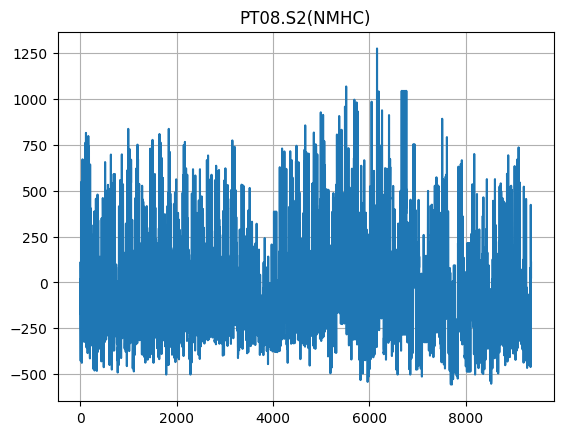

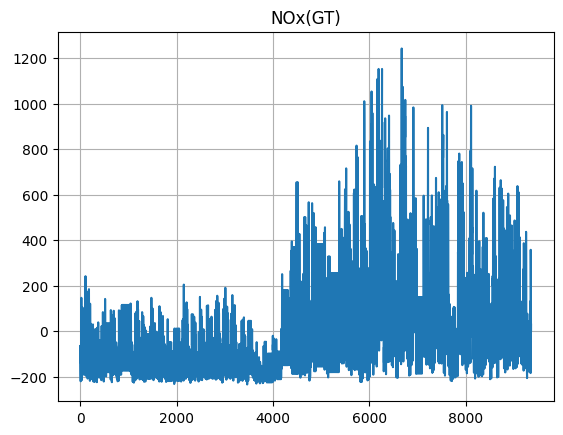

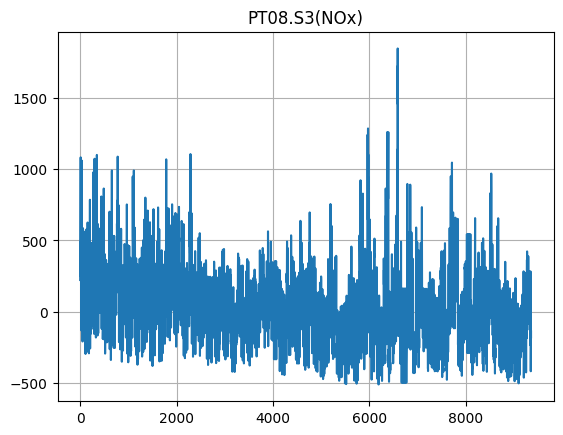

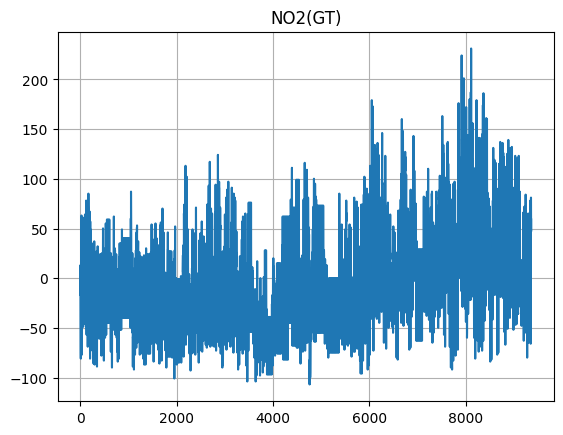

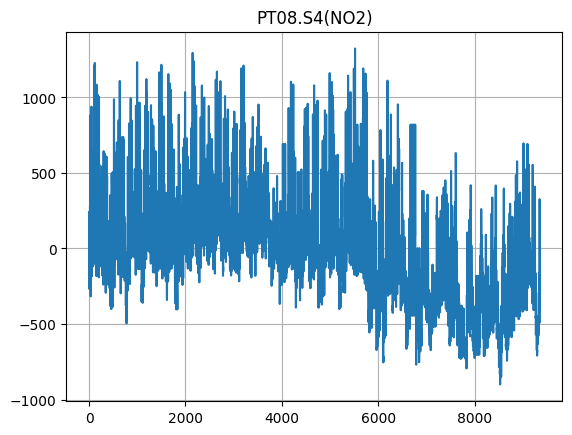

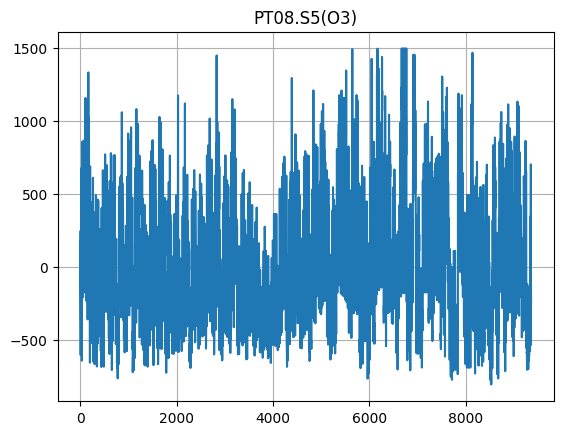

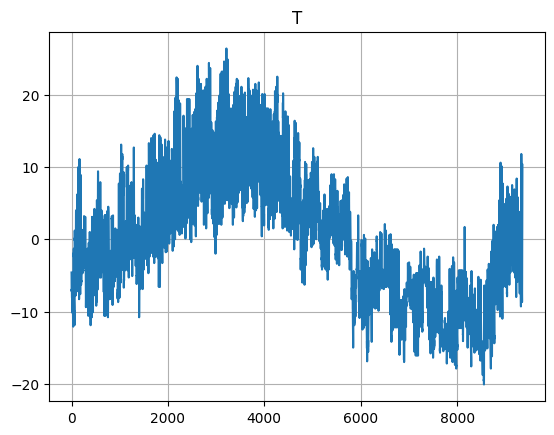

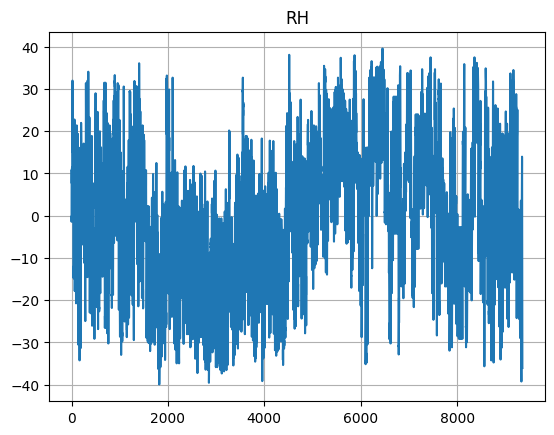

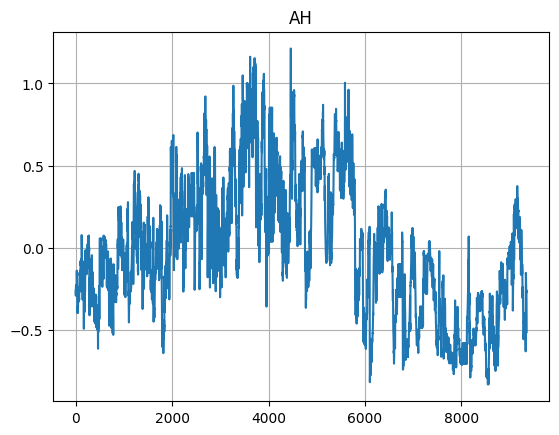

In [4]:
import matplotlib.pyplot as plt

for col in X.columns[2:]:
    X[col] = X[col] - np.mean(X[col]) #demean 
    fig, ax = plt.subplots()
    plt.plot(X[col])
    ax.title.set_text(col)
    ax.grid()
    plt.show()

## Generating all the sensors couples and computing Normalized Cross Correlation

In [5]:
from itertools import combinations
sensors_combinations = list(combinations(X.columns[2:], 2))
print(len(sensors_combinations))
cross_correlations = {}

for (s1,s2) in sensors_combinations:
 
    cross_corr = np.correlate(X[s1], X[s2], mode='full')
    
    # Compute autocovariances. Mode="valid" indicates computation at lag 0
    autocorr_x = np.correlate(X[s1], X[s1], mode='valid')
    autocorr_y = np.correlate(X[s2], X[s2], mode='valid')

    # Compute square root of the product of autocovariances
    sqrt_autocov_product = np.sqrt(autocorr_x * autocorr_y)
    
    # Normalize the cross-correlation
    norm_cross_corr = cross_corr / sqrt_autocov_product
    
    cross_correlations.update({f"{s1},{s2}": norm_cross_corr})

66


## Plotting the Cross Correlations
We check the absolute value to account for anticorrelation peaks (negative values) as well

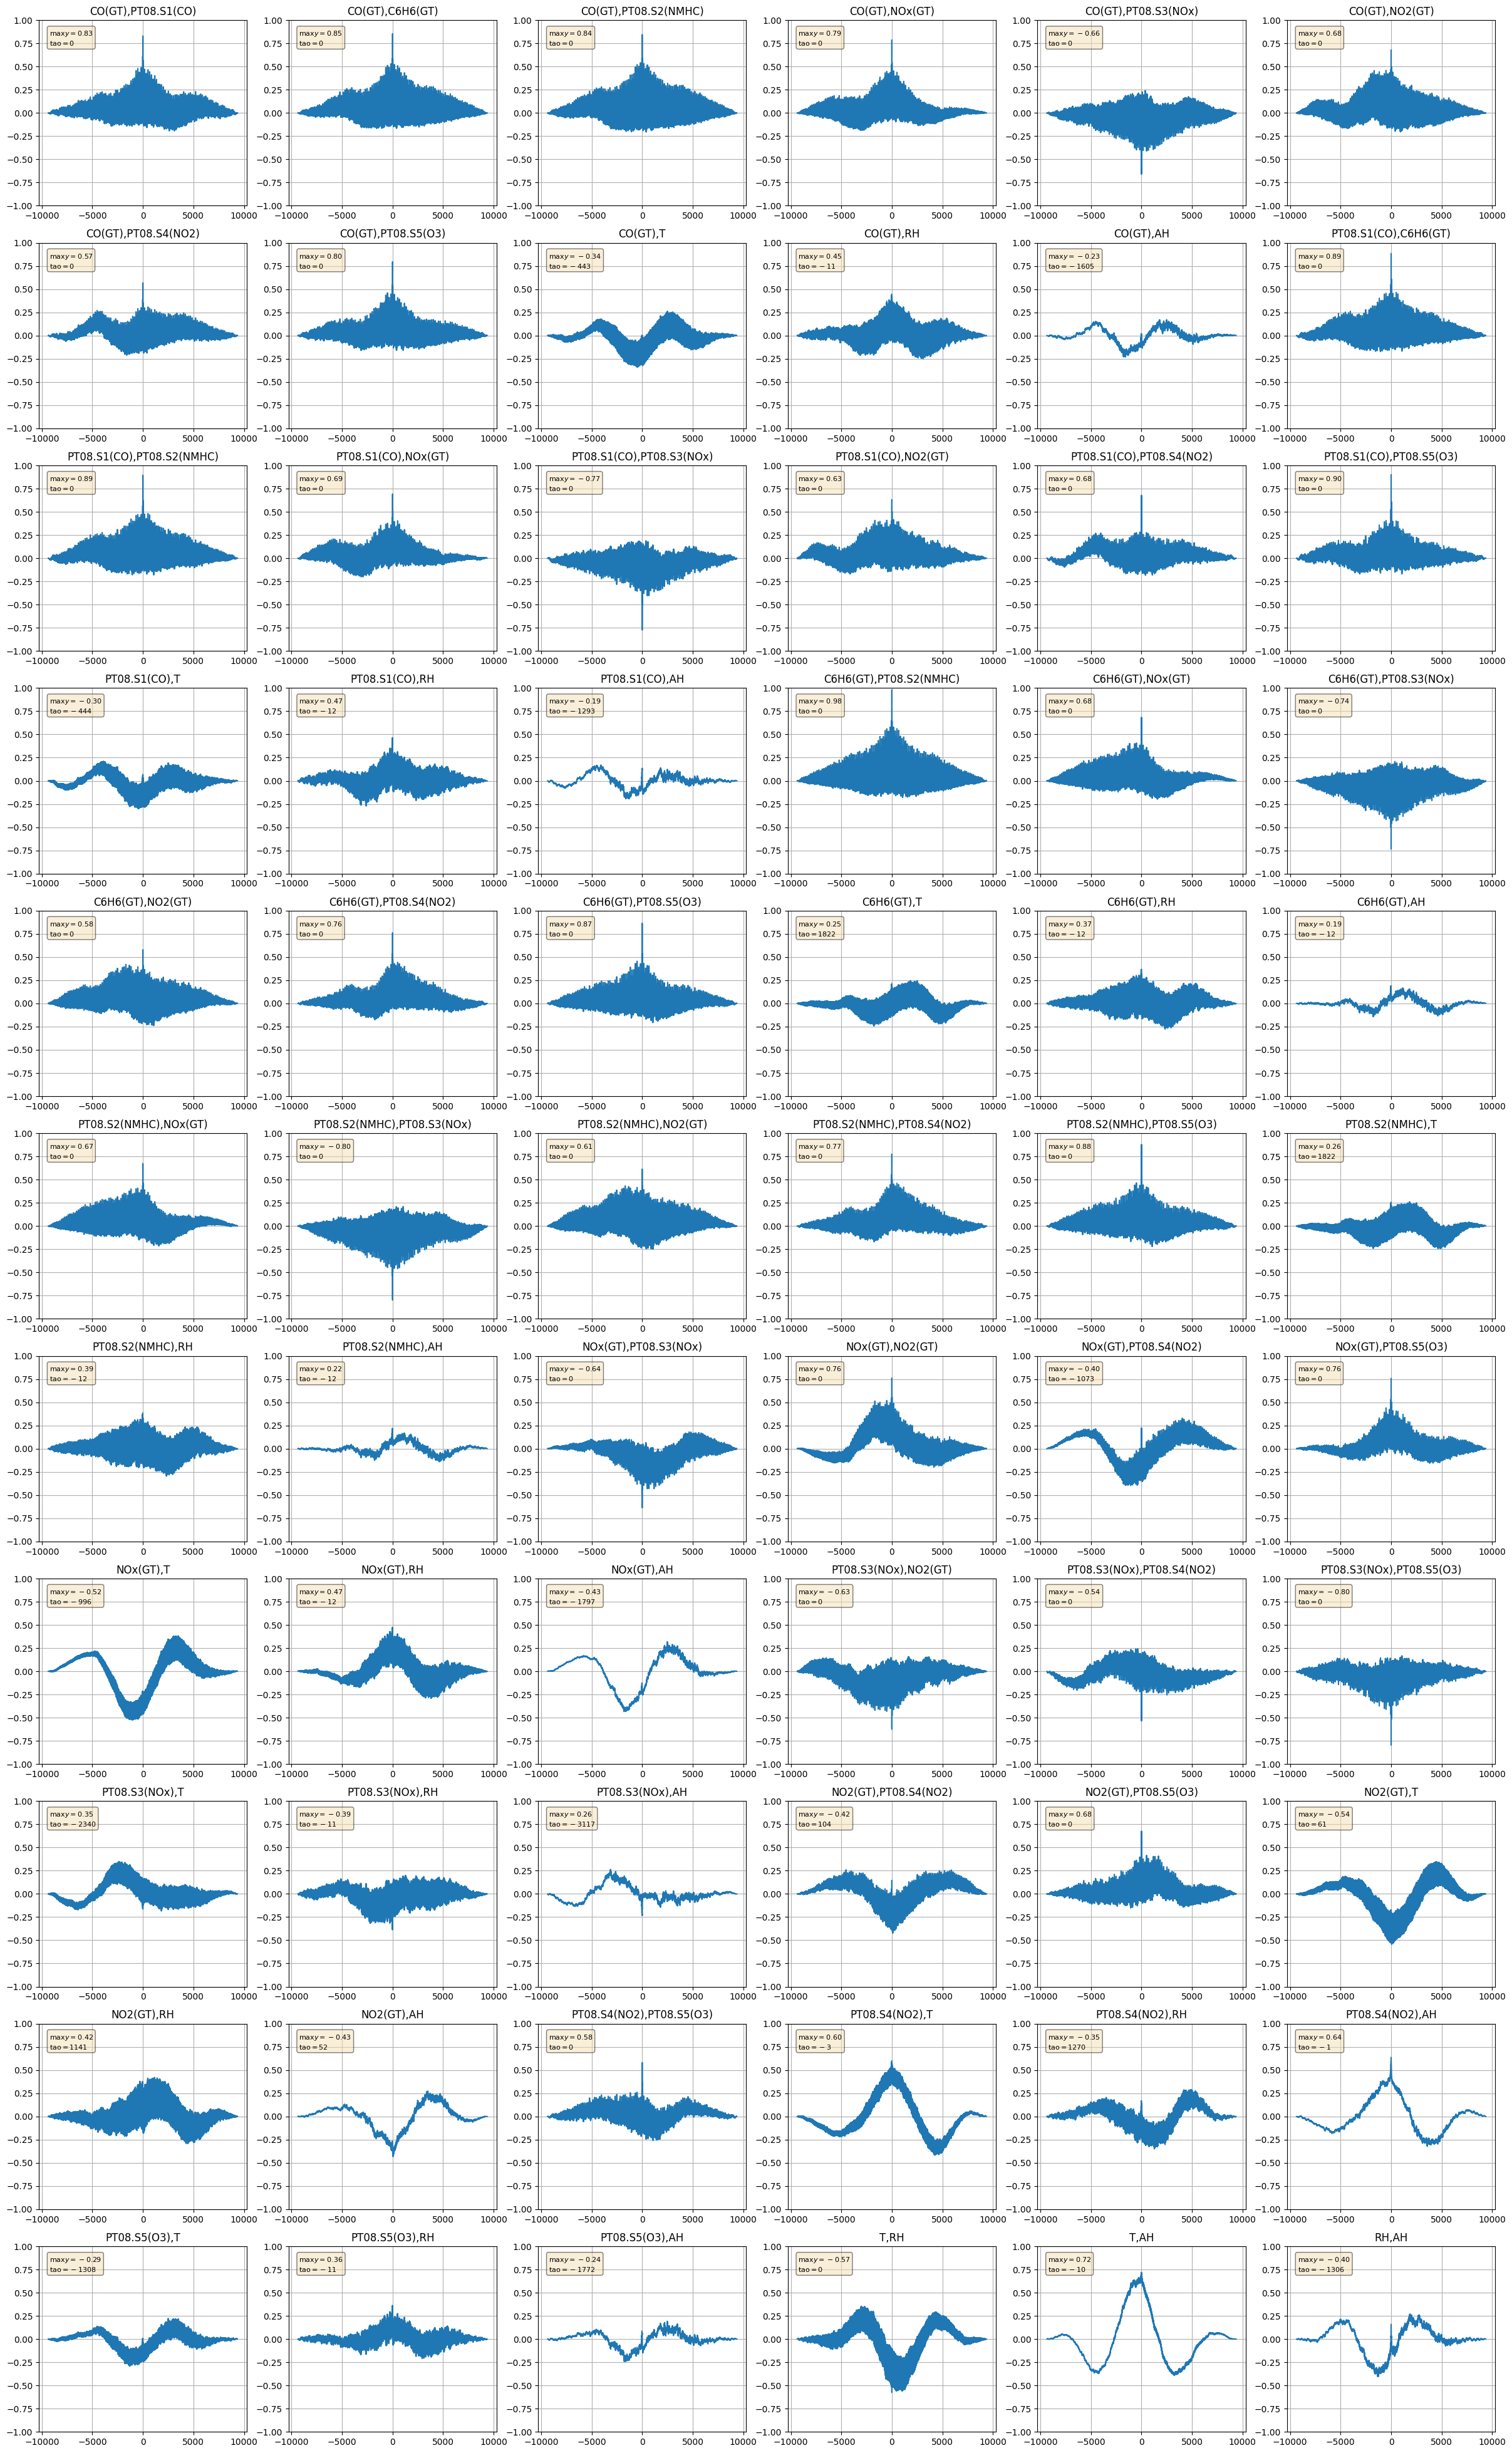

In [6]:
plt.rcParams["figure.figsize"] = (30, 50)

fig, axs = plt.subplots(nrows=int(len(cross_correlations) /6), ncols=6)
lags = np.arange(-(X.shape[0] -1), X.shape[0] ) # -1 because, since we shifted the x axis to be centered in 0, we have an extra value

axs = axs.flatten()
for ax, data in zip(axs, cross_correlations.items()):
    ax.grid()
    ax.plot(lags, data[1])
    # Add labels to the plot
    ax.title.set_text(data[0])
    ax.set_ylim([-1.0, 1.0])
    max_y = max(data[1], key= abs) #considering anticorrelation (negative values) as well
    tao, = np.where(data[1] == max_y)[0] -X.shape[0] + 1 #compensate for the shift
    # Display the plot
    textstr = '\n'.join((
    r'$\max y=%.2f$' % (max_y, ),
    r'$\mathrm{tao}=%d$' % (tao , )))


    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', bbox=props)
    
plt.show()

In [7]:
import pandas as pd
df = pd.DataFrame(cross_correlations)
df.max().sort_values(ascending=False)
plot = df.plot( kind="bar")


# Results Analysis
By looking at the plots, we can see that some sensors are definitely more correlated than others. This is shown by the peak which, when it is present and substantial, often appears at lag 0: the point on which the two frequencies align. In other cases (for less accentuated peaks) it is in proximity of the 0 anyway. This presumably happens because, being the cross-correlation a "sliding dot product", if the signals are actually correlated, it will tendentially have lower values at extremities and higher values towards the middle, due to signals not overlapping and having a product of 0, lowering the summation. 
Given that each lag step represents an hour, peaks occurring in a Tao != 0 shows a "shifted" correlation between the signals: for example, in the "PT08.S4(NO2), AH" plot, there is a peak at -1; this means that values from the second sensor are correlated to the ones from the first, but are visible after an hour (of course, order is important: if we invert the two sensors the plot is inverted and we get maximum correlation at tao = 1).

Other than that, we can see many sinusoid-shaped plots: that shows that there is a certain degree of cyclic relationship between those values, they seem to not be always correlated, or to be such in the same way. 

# Zooming in
That's a lot of plots, and they're all crammed together. Let's take the couple with the higher correlation ('C6H6(GT),PT08.S2(NMHC))' -> 0.98, and take a look at what happens in the middle.
By restricting on (-100, 100) on the X axis we can see that we get local peaks every 24 hours. That is to be expected: it means that the measurements are similar when they are taken at the same hour of the day, and the cross correlation is higher because the shapes overlap. 

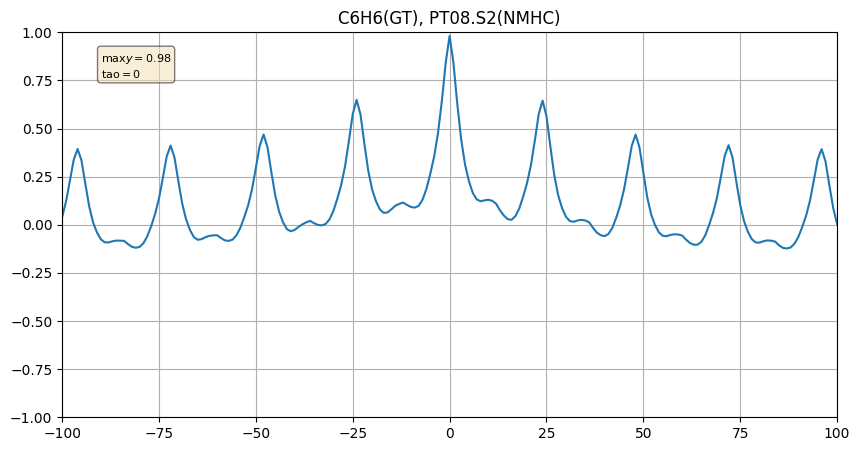

In [ ]:
fig, ax = plt.subplots()
plt.plot(lags, cross_correlations['C6H6(GT),PT08.S2(NMHC)'])

ax.grid()

lags = np.arange(-(X.shape[0]-1 ), X.shape[0])
plt.rcParams["figure.figsize"] = (10, 5)

# Add labels to the plot
ax.title.set_text('C6H6(GT), PT08.S2(NMHC)')
ax.set_ylim([-1.0, 1.0])
max_y = max(cross_correlations['C6H6(GT),PT08.S2(NMHC)'], key= abs)
tao, = np.where(cross_correlations['C6H6(GT),PT08.S2(NMHC)'] == max_y)[0] -X.shape[0] + 1
# Display the plot
textstr = '\n'.join((
r'$\max y=%.2f$' % (max_y, ),
r'$\mathrm{tao}=%d$' % (tao , )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

ax.set_xlim(-100, 100)
plt.show()
